# ASPEN Paper - Figure 6 and its supplement

In [2]:
#Loading libraries 

.libPaths( c( .libPaths(), "/home/114/vp4925/R/x86_64-pc-linux-gnu-library/4.1") ) 
suppressPackageStartupMessages({
    library(openxlsx)
    library(scales)
    library(scater)
    library(dplyr)
    library(gamlss)
    library(ggplot2)
    library(ggpointdensity)
    library(ggsci)
    library(ggthemes)
    library(ggpubr)
    library(gridExtra)
    library(foreach)
    library(reshape2)
    library(ComplexHeatmap)
    library(ggrepel)
    library(locfit)
    library(scran)
    library(zoo)
    library(jcolors)
    library(MatchIt)
    library(plyr)
    library(ggVennDiagram)
    library(ggvenn)
    library(VennDiagram)
    library(dplyr)
    library(stats)
    library(clusterProfiler)
    library(org.Mm.eg.db)
    library(ASPEN)
})

Functions that were used for the analyses

In [28]:
plot_scatter <- function(param_reestim){

  ggplot(param_reestim, aes(log(tot_gene_mean), log(bb_theta))) +
    geom_point(size = 0.7, colour = "darkgrey") +
    geom_line(aes(log(tot_gene_mean), log(theta_common)), color = "black", linewidth = 1, group = 1) +
    theme_classic(base_size = 20) +
    theme(legend.position = "none", legend.title = element_blank()) +
    annotate("text", x=2, y=3.5, label= paste("N genes:", nrow(param_reestim)), size = 6) 
  
}

# Function to prepare data for plotting
# extracting allelic and total counts
makedf <- function(a1_counts, tot_counts, metadata, gene){
      
      df <- as.data.frame(cbind(a1 = a1_counts[gene,], tot = tot_counts[gene,]))
      df$a2 <- df$tot - df$a1   
      df$AR <- df$a1/df$tot
      df$cell_type <- metadata$orig.ident[match(rownames(df), rownames(metadata))]
      df$cell_type <- factor(df$cell_type, levels = c("cd8_naive", "cd8_d07_lcmv_arms", "cd8_d40_lcmv_arms"))
      df <- df[order(df$cell_type),]    
      df$Index <- 1:nrow(df)
      df <- na.omit(df)  
      df
}
    
# Plotting allelic ratio distribution
# cells are coloured by log(total counts)
plot_distr_totGE <- function(plot_data){
    
    p <- plot_data %>% ggplot(aes(updIndex, AR, colour = log(tot))) +
        theme_classic(base_size = 20) +
        geom_pointdensity(size = 0.9) +
        theme(plot.subtitle = element_text(hjust = 1)) +
        scale_colour_viridis_c(option = "mako", direction = -1) + #, limits=c(0, 6)) +
        theme(legend.position = "bottom", legend.box.spacing = unit(0, "pt")) +
        labs(x = "Ordered pseudotime", y = "Allelic ratio") +
        geom_vline(xintercept = plot_data$updIndex[match(unique(plot_data$cell_type), plot_data$cell_type)][-1]) +
        coord_flip()
    p
    
}


geBoxplot <- function(plot_data, strain = "Spret"){
  #data for the boxplot
  a1_counts <- data.frame(plot_data[,c(1,5)], allele = "Bl6")
  colnames(a1_counts)[1] <- "counts"
  a2_counts <- data.frame(plot_data[,c(3,5)], allele = strain)
  colnames(a2_counts)[1] <- "counts"
  boxplot_dt <- data.frame(rbind(a1_counts, a2_counts))
  boxplot_dt <- na.omit(boxplot_dt)
  boxplot_dt$log2counts <- log2(boxplot_dt$counts)
  boxplot_dt$allele <- factor(boxplot_dt$allele, levels = c("Spret", "Bl6"))  

  ggboxplot(boxplot_dt, x = "cell_type", y = "log2counts", ylab = "Log2 counts",  
            ggtheme=theme_pubr(base_size = 15), fill = "allele", 
            palette = c("#3300CC", "#CC0033"),
            orientation = "vertical") +
    theme(legend.position = "top", legend.title = element_blank(), axis.title.x = element_blank()) +
    stat_compare_means(aes(group = allele), method = "wilcox.test", label = "p.signif", label.y = 6.5) +
    theme(plot.margin = margin(0.3,0.3,0,0.3, "cm")) +
    ylim(c(0,7))
  
}

### Figure 6A

Visualising deviation from the common trend for genes with ASPEN-var FDR < 0.05 in T-cells dataset.

In [ ]:
#loading joint total and a1 counts
data_dir <-  "./data/tcells/"

tcells_tot_sce <- readRDS(paste0(data_dir, "merged_tcells_tot_sce.rds")) 
tcells_a1_sce <- readRDS(paste0(data_dir, "merged_tcells_a1_sce.rds")) 
tcells_a1_sce <- tcells_a1_sce[rownames(tcells_tot_sce), ]

metadata <- as.data.frame(colData(tcells_tot_sce))
metadata$group <- metadata$orig.ident
table(metadata$group)

In [ ]:
grouping <- split(metadata, f = metadata$group)
#splitting total and allelic count by cell state
tcells_tot_sce_split <- lapply(grouping, function(q) tcells_tot_sce[,rownames(q)])
tot_sce_filt <- lapply(tcells_tot_sce_split, function(q) q[rowSums(assays(q)[['counts']] > 1) >= 10, ]) 
tot_mat <- lapply(tot_sce_filt, function(q) as.matrix(assays(q)[['counts']]))

tcells_a1_sce_split <- lapply(grouping, function(q) tcells_a1_sce[,rownames(q)])
a1_mat <- lapply(tcells_a1_sce_split, function(q) as.matrix(assays(q)[['counts']]))
a1_mat <- mapply(function(p,q) p[rownames(q), ], a1_mat, tot_mat, SIMPLIFY = F)

In [ ]:
#using ASPEN to estimate beta-binomial parameters
param_estims_tcells <- mapply(function(p, q) estim_bbparams(p, q, min_cells = 5, cores = 12),
                            a1_mat, tot_mat, SIMPLIFY = F)

param_reestims_tcells <- lapply(param_estims_tcells, function(q) correct_theta(q, delta_set = 50, N_set = 30, thetaFilter = 1e-03))

In [ ]:

#Loading ASPEN test results which excludes sex chromosome, imprinted and ribosomal genes 
samples <- list("cd8_d07_lcmv_arms", "cd8_d40_lcmv_arms", "cd8_naive")
res_dir <- "./aspen_output/tcells/test_res/"
bb_test_res_tcells_filt <- lapply(samples, function(q) read.xlsx(paste0(res_dir, "tcells_lcmv_ASPENmeanvar_nochrX.xlsx"),
                                                            sheet = q, rowNames = T))

In [ ]:
#recalculating FDR
bb_test_res_tcells_filt <- lapply(bb_test_res_tcells_filt, function(q) {q$fdr_mean <- p.adjust(q$pval_mean, method = "fdr");
                                                   q$fdr_var <-  p.adjust(q$pval_var, method = "fdr");
                                                    q$vardeviat <- ifelse(q$fdr_var < 0.05, 1, 0);
                                                    q$gene <- rownames(q);
                                                              return(q)})

In [ ]:
param_reestims_tcells <- mapply(function(p,q) {p$vardeviat <- ifelse(match(rownames(p), rownames(q)[q$vardeviat == 1]), 1, 0);
                                               return(p)}, param_reestims_tcells, bb_test_res_tcells_filt, SIMPLIFY = F)
  

In [ ]:
p <- mapply(function(p, q) plot_scatter(p) +
    geom_hline(yintercept = log(1e-03), linetype = "dashed", linewidth = 0.5) +
    geom_point(data = subset(p, greater_var == 1), colour = "#A73030FF", size = 0.7) +
   annotate("text", x=1, y=4.5, label= paste0("N sign var genes:", table(p$vardeviat)), size = 6) +
            labs(subtitle = q),
           param_reestims_tcells[c(3,1,2)], samples[c(3,1,2)], SIMPLIFY = F)

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 4.5)
p <- do.call(grid.arrange, c(p, ncol = 3))
p

### Supplemental Figure 5A

GO term enrichment analyses

In [ ]:
#combining test results into one data frame
bb_test_res_tcells_filt <- mapply(function(p, q) {p$sample <- q; return(p)},
                                 bb_test_res_tcells_filt, samples, SIMPLIFY = F)
tcells_comb <- do.call(rbind, bb_test_res_tcells_filt)


In [ ]:
#identifying genes with low and high dispersion that significantly deviate from the expected trend
tcells_comb$disp_group <- ifelse(tcells_comb$fdr_var < 0.05 & tcells_comb$bb_theta < tcells_comb$theta_common, "lowdisp", NA)
tcells_comb$disp_group <- ifelse(tcells_comb$fdr_var < 0.05 & tcells_comb$bb_theta > tcells_comb$theta_common, "highdisp", tcells_comb$disp_group)
table(tcells_comb$disp_group)

In [ ]:
#defining background and converting gene names to ENTREZ IDs
genes <- unique(tcells_comb$gene)
bkg_genes <- bitr(genes, fromType = c("SYMBOL"), toType = "ENTREZID", OrgDb = org.Mm.eg.db)
#converting gene names to ENTREZ IDs
high_disp_genes <- bitr(unique(tcells_comb$gene[tcells_comb$disp_group == "highdisp"]), fromType = c("SYMBOL"), toType = "ENTREZID", OrgDb = org.Mm.eg.db)
low_disp_genes <- bitr(unique(tcells_comb$gene[tcells_comb$disp_group == "lowdisp" & tcells_comb$tot_gene_mean < 100]), fromType = c("SYMBOL"), toType = "ENTREZID", OrgDb = org.Mm.eg.db)


Set enrichment analyses for the genes with low dispersion

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 9)
ego_sets_lowdisp <- enrichGO(gene = low_disp_genes$ENTREZID,
                             universe = bkg_genes$ENTREZID,
                             OrgDb = org.Mm.eg.db,
                             ont = "BP", #"MF",
                             pAdjustMethod = "BH",
                             pvalueCutoff  = 1,
                             qvalueCutoff  = 1,
                             readable = TRUE)

ego_res <- dotplot(ego_sets_lowdisp, showCategory = 10, font.size=14) +
                   scale_colour_viridis_c(limits=c(1e-04, 1), option = "plasma") +
                   theme(legend.position = "bottom", plot.subtitle = element_text(hjust = 1)) +
                   labs(subtitle = "Ontology - BP", title = "Bl6Spret_tcells", caption = "Genes with low dispersion")
ego_res

In [ ]:
ego_sets_lowdisp@result[1:10,]

GO set enrichment analyses for the genes with high dispersion

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 9)
ego_sets_highdisp <- enrichGO(gene = high_disp_genes$ENTREZID,
                             universe = bkg_genes$ENTREZID,
                             OrgDb = org.Mm.eg.db,
                             ont = "BP", #"MF",
                             pAdjustMethod = "BH",
                             pvalueCutoff  = 0.1,
                            qvalueCutoff  = 0.1,
                            readable = TRUE)

ego_res <- dotplot(ego_sets_highdisp, showCategory = 10, font.size=14) +
                   scale_colour_viridis_c(limits=c(1e-04, 1e-01), option = "plasma") +
                   theme(legend.position = "bottom", plot.subtitle = element_text(hjust = 1)) +
                   labs(subtitle = "Ontology - BP", title = "Bl6Spret_tcells", caption = "Genes with high dispersion")
ego_res

In [ ]:
ego_sets_highdisp@result[1:10,] 

### Figure 6B

Selecting genes that significantly deviate from the expected levels of dispersion for genes with similar expression

In [ ]:
bb_test_res_tcells_select <- lapply(bb_test_res_tcells_filt, function(q) q[q$fdr_var < 0.05,])
bb_test_res_tcells_select <- lapply(bb_test_res_tcells_select, function(q) q[order(q$fdr_var),])
bb_test_res_tcells_select <- lapply(bb_test_res_tcells_select, function(q) q[1:18,])                                     
genes <- unique(c(rownames(bb_test_res_tcells_select[[1]]), 
                  rownames(bb_test_res_tcells_select[[2]]), 
                  rownames(bb_test_res_tcells_select[[3]])))
length(genes)

In [ ]:
#building a table with mean AR values per cell type for plotting
bb_test_res_tcells_disp <- lapply(bb_test_res_tcells_filt, function(q) q[genes,])
#extracting dispersion estimates
top20genes_disp <- lapply(bb_test_res_tcells_disp, function(q) q[,"bb_theta"])
top20genes_disp <- do.call("cbind", top20genes_disp)
colnames(top20genes_disp) <- c("cd8_d07", "cd8_d40", "cd8_naive")
rownames(top20genes_disp) <- genes 
#re-ordering table columns
top20genes_disp <- top20genes_disp[,c(3,1,2)]
top20genes_disp <- na.omit(top20genes_disp)
head(top20genes_disp)

In [ ]:
#scale by column
disp_zscore <- t(scale(t(top20genes_disp), scale=TRUE, center=TRUE))
disp_zscore <- na.omit(disp_zscore)
head(disp_zscore)

In [ ]:
options(repr.plot.width = 4, repr.plot.height = 5.5)
cont_pal <- viridis_pal(option = "G", direction = -1)(11) 
ht <- ComplexHeatmap::Heatmap(disp_zscore, cluster_rows = T, cluster_columns = FALSE, #col = cont_pal, 
                        heatmap_legend_param = list(direction = "horizontal", at = seq(-1.5, 0, 1.5)), name = "Dispersion z-score",
                        col = circlize::colorRamp2(c(-1, 0, 1),  cont_pal[c(2,4,8)]),      
                        row_names_side = "right")
draw(ht, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"))

### Supplemental Figure 5B

Plotting allelic ratios for the genes with ASPEN-var FDR < 0.05

In [ ]:
#keeping the same genes
genes <- rownames(disp_zscore)
#building a table with mean AR values per cell type for plotting
bb_test_res_tcells_select <- lapply(bb_test_res_tcells_filt, function(q) q[genes,])
#selecting allelic ratio estimated using raw counts
top20genes_ar <- lapply(bb_test_res_tcells_select, function(q) q[,"AR"])
top20genes_ar <- do.call("cbind", top20genes_ar)
colnames(top20genes_ar) <- c("cd8_d07", "cd8_d40", "cd8_naive")
rownames(top20genes_ar) <- genes 
#re-ordering table columns
top20genes_ar <- top20genes_ar[,c(3,1,2)]   
top20genes_ar <- na.omit(top20genes_ar)
#re-ordering row as per the dispersion heatmap
top20genes_ar <- top20genes_ar[row_order(ht),]  
head(top20genes_ar)

In [ ]:
cont_pal <- pal_gsea()(11)
ht2 <- ComplexHeatmap::Heatmap(top20genes_ar, cluster_rows = FALSE, cluster_columns = FALSE, #col = cont_pal, 
                        heatmap_legend_param = list(direction = "horizontal", at = seq(0, 1, 0.25)), name = "Allelic Ratio",
                        col = circlize::colorRamp2(c(0.25, 0.5, 0.75),  cont_pal[c(1,6,11)]), 
                        row_names_side = "right")
draw(ht2, heatmap_legend_side = "bottom", ht_gap = unit(0.1, "cm"))

### Figure 6C

Loading ASPEN dyn-mean and dyn-var test result for the ASE distribution changes during T-cells activation

In [ ]:
res_dir <- "./aspen_output/tcells/"
pseudot_change <- read.xlsx(paste0(res_dir, "tcells_lcmv_ASPENdyn.xlsx"))

Finding the overlap between the genes with changes in the mean and variance

In [4]:
#selecting genes with significant allelic imbalance
dynamic_test_res <- list(
  "Changes in mean" = rownames(pseudot_change)[pseudot_change$fdr_mean < 0.05], 
  "Changes in variance" = rownames(pseudot_change)[pseudot_change$fdr_var < 0.05]
)

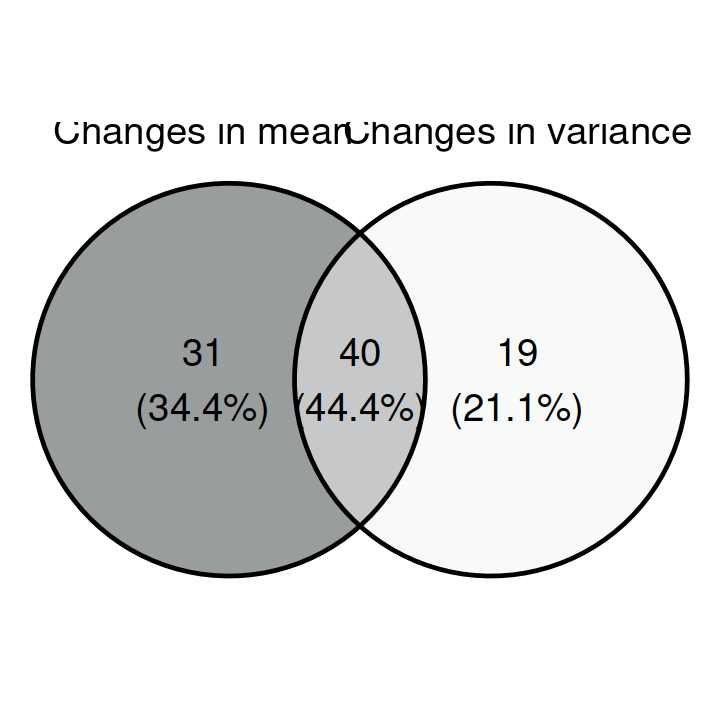

In [5]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggvenn(dynamic_test_res, fill_color = c("#373D3F", "#F2F3F4"),
       text_size = 8, set_name_size = 8)

Using draw.pairwise.venn function to make the size of overlap proportional to the number of genes

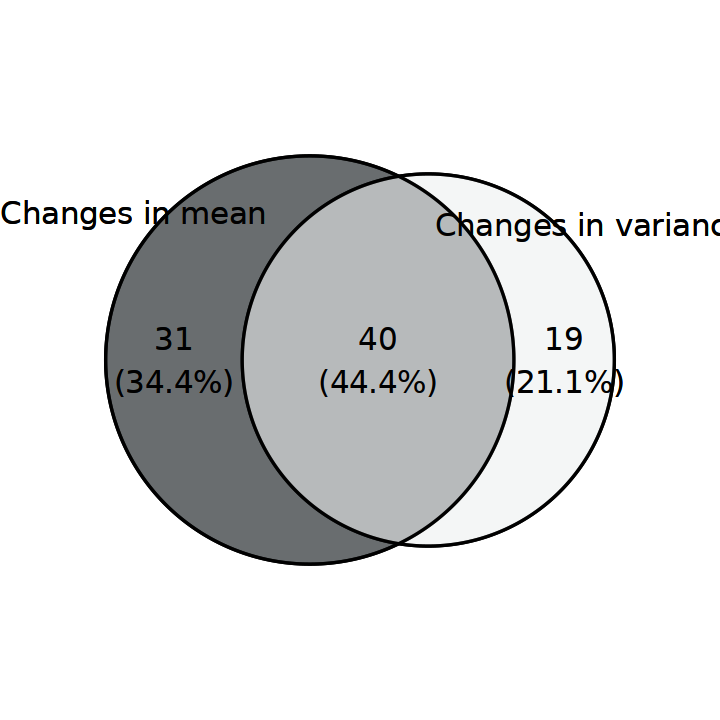

In [6]:
options(repr.plot.width = 6, repr.plot.height = 6)
venn.plot <- draw.pairwise.venn(area1 = 71, area2 = 59, cross.area = 40,
                   category=c("Changes in mean","Changes in variance"), fill=c("#373D3F", "#F2F3F4"), #fill=c("#0073C2FF", "#CD534CFF"),  
                   print.mode = c('raw','percent'),
                   alpha = rep(0.5, 1), cex = 1.5, cat.cex = 1.5, cat.fontfamily = 2, fontfamily = 2, margin = 0.1)
grid.draw(venn.plot)

### Figure 6D and Supplemental Figure 5C

Allelic ratio distribution for the genes that have changes during T-cell activation either in the allelic mean only, allelic variance only or both.

In [4]:
#extracting reference and total count matrices
a1_counts <- assays(tcells_a1_sce)[["counts"]]
tot_counts <- assays(tcells_tot_sce)[["counts"]]

In [21]:
gene <- "Grap2"
plot_data <- makedf(a1_counts, tot_counts, metadata, gene = gene)
head(plot_data)

,a1,tot,a2,AR,cell_type,Index
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>
cd8_naive_AACCATGAGATGGCGT,0,3,3,0.0000000,cd8_naive,1
cd8_naive_AACCATGAGCGCCTTG,0,6,6,0.0000000,cd8_naive,2
cd8_naive_AACCATGGTATCTGCA,0,1,1,0.0000000,cd8_naive,3
cd8_naive_ACACCAAAGATTACCC,2,3,1,0.6666667,cd8_naive,4
cd8_naive_ACACCAAAGCGATGAC,1,3,2,0.3333333,cd8_naive,5
cd8_naive_ACACCAACAGACAAGC,0,1,1,0.0000000,cd8_naive,6


In [8]:
#cells that have 0 total count are excluded
#this create unequal group sizes 
#for plotting the groups are rescaled
table(plot_data$cell_type)


        cd8_naive cd8_d07_lcmv_arms cd8_d40_lcmv_arms 
              624               337               438 

In [17]:
#function to rescale numeric values
#chose to rescale to 337 because it is the number of cells in day 7 group - the smallest group of three
fn <- function(x) x * 337/max(x, na.rm = TRUE)
plot_data_split <- split(plot_data, f = plot_data$cell_type)
plot_data_split[[1]]$Index <- 1:nrow(plot_data_split[[1]])
#recaling index for the naive group
plot_data_split[[1]]$updIndex <- fn(plot_data_split[[1]]$Index)
#undating index for day 7
plot_data_split[[2]]$updIndex <- seq(from = 337, to =673, by =1)
plot_data_split[[3]]$Index <- 1:nrow(plot_data_split[[3]])
plot_data_split[[3]]$updIndex <- 674 + fn(plot_data_split[[3]]$Index)
#merging the group level information together
plot_data_merge <- rbind(plot_data_split[[1]], plot_data_split[[2]], plot_data_split[[3]])

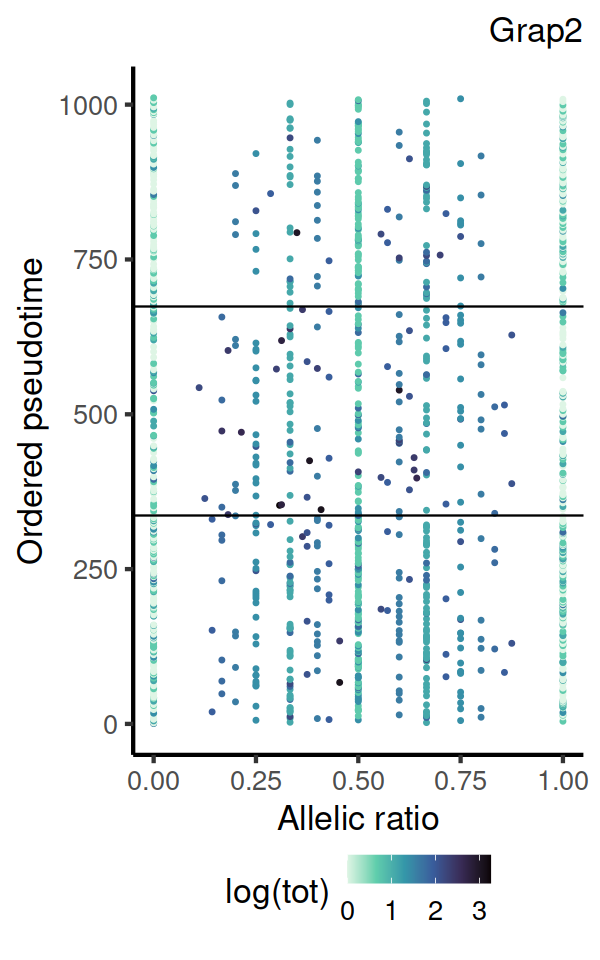

In [18]:
options(repr.plot.width = 5, repr.plot.height = 8)
scatter <- plot_distr_totGE(plot_data_merge)

scatter + labs(subtitle = gene)

Warning message:
“Removed 681 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 681 rows containing non-finite outside the scale range
(`stat_compare_means()`).”


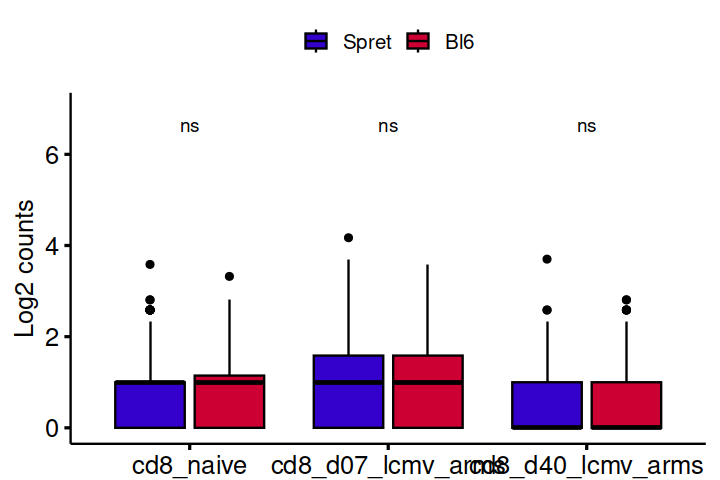

In [29]:
options(repr.plot.width = 6, repr.plot.height = 4)
boxplot <- geBoxplot(plot_data)
boxplot 

In [30]:
gene <- "Trbc1"
plot_data <- makedf(a1_counts, tot_counts, metadata, gene = gene)
table(plot_data$cell_type)


        cd8_naive cd8_d07_lcmv_arms cd8_d40_lcmv_arms 
              426               284               492 

In [32]:
#function to rescale numeric values
#chose to rescale to 284 because it is the number of cells in day 7 group - the smallest group of three
fn <- function(x) x * 284/max(x, na.rm = TRUE)
plot_data_split <- split(plot_data, f = plot_data$cell_type)
plot_data_split[[1]]$Index <- 1:nrow(plot_data_split[[1]])
#recaling index for the naive group
plot_data_split[[1]]$updIndex <- fn(plot_data_split[[1]]$Index)
#undating index for day 7
plot_data_split[[2]]$updIndex <- seq(from = 285, to =568, by =1)
plot_data_split[[3]]$Index <- 1:nrow(plot_data_split[[3]])
plot_data_split[[3]]$updIndex <- 569 + fn(plot_data_split[[3]]$Index)
#merging the group level information together
plot_data_merge <- rbind(plot_data_split[[1]], plot_data_split[[2]], plot_data_split[[3]])

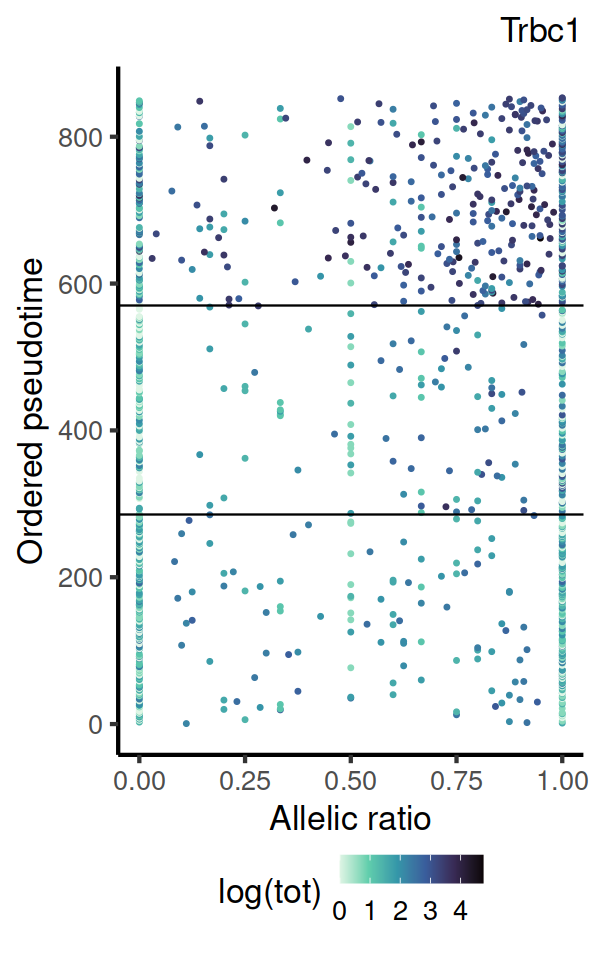

In [33]:
options(repr.plot.width = 5, repr.plot.height = 8)
scatter <- plot_distr_totGE(plot_data_merge)

scatter + labs(subtitle = gene)

Warning message:
“Removed 381 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 381 rows containing non-finite outside the scale range
(`stat_compare_means()`).”


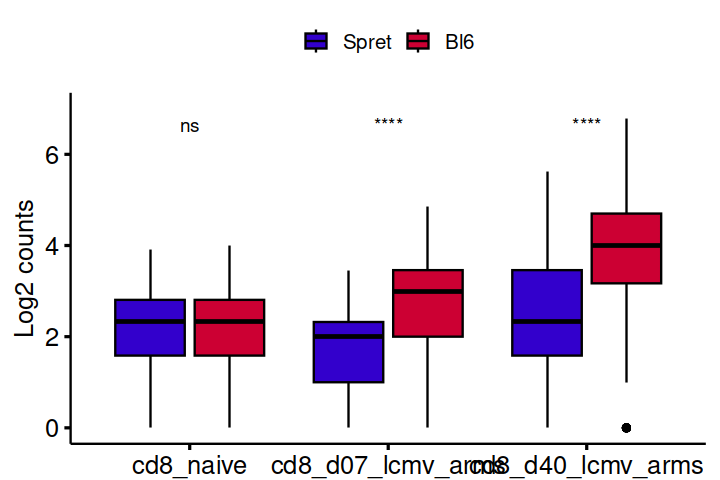

In [39]:
options(repr.plot.width = 6, repr.plot.height = 4)
boxplot <- geBoxplot(plot_data[plot_data$tot >= 4,])
boxplot 

In [40]:
gene <- "Actb"
plot_data <- makedf(a1_counts, tot_counts, metadata, gene = gene)
table(plot_data$cell_type)


        cd8_naive cd8_d07_lcmv_arms cd8_d40_lcmv_arms 
              679               394               581 

In [41]:
#function to rescale numeric values
#chose to rescale to 394 because it is the number of cells in day 7 group - the smallest group of three
fn <- function(x) x * 394/max(x, na.rm = TRUE)
plot_data_split <- split(plot_data, f = plot_data$cell_type)
plot_data_split[[1]]$Index <- 1:nrow(plot_data_split[[1]])
#recaling index for the naive group
plot_data_split[[1]]$updIndex <- fn(plot_data_split[[1]]$Index)
#undating index for day 7
plot_data_split[[2]]$updIndex <- seq(from = 395, to =788, by =1)
plot_data_split[[3]]$Index <- 1:nrow(plot_data_split[[3]])
plot_data_split[[3]]$updIndex <- 789 + fn(plot_data_split[[3]]$Index)
#merging the group level information together
plot_data_merge <- rbind(plot_data_split[[1]], plot_data_split[[2]], plot_data_split[[3]])

In [42]:
head(plot_data_merge)

,a1,tot,a2,AR,cell_type,Index,updIndex
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<dbl>
cd8_naive_AACCATGAGATGGCGT,8,16,8,0.5000000,cd8_naive,1,0.5802651
cd8_naive_AACCATGGTATCTGCA,10,15,5,0.6666667,cd8_naive,2,1.1605302
cd8_naive_ACACCAAAGATTACCC,14,18,4,0.7777778,cd8_naive,3,1.7407953
cd8_naive_ACACCAAAGCGATGAC,1,6,5,0.1666667,cd8_naive,4,2.3210604
cd8_naive_ACACCAACAGACAAGC,3,4,1,0.7500000,cd8_naive,5,2.9013255
cd8_naive_ACACCAACAGTTTACG,6,10,4,0.6000000,cd8_naive,6,3.4815906


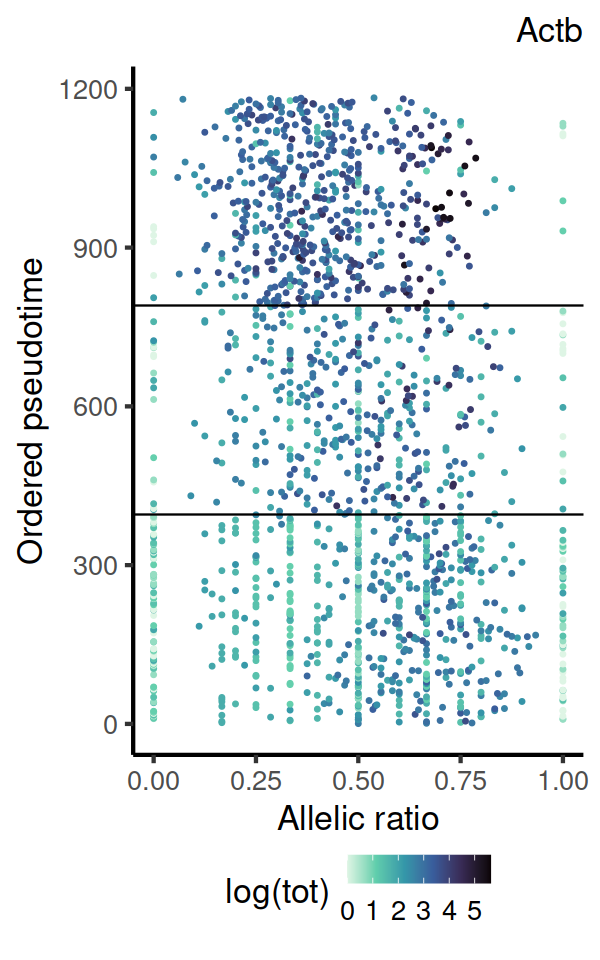

In [43]:
options(repr.plot.width = 5, repr.plot.height = 8)
scatter <- plot_distr_totGE(plot_data_merge)

scatter + labs(subtitle = gene)

Warning message:
“Removed 195 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 195 rows containing non-finite outside the scale range
(`stat_compare_means()`).”


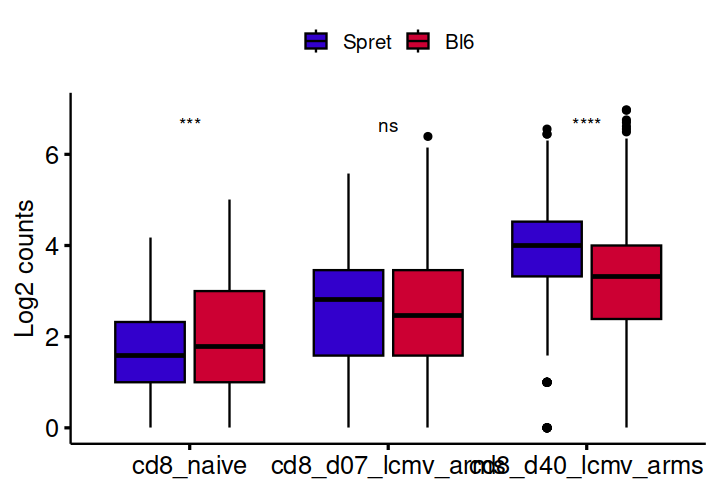

In [44]:
options(repr.plot.width = 6, repr.plot.height = 4)
boxplot <- geBoxplot(plot_data)
boxplot 